## Setup

In [12]:
import glob
import os
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import colorsys
from pathlib import Path
from matplotlib.lines import Line2D
import seaborn as sns

import numpy as np
from adjustText import adjust_text

from moral_lens.models import load_model_config


TAXONOMY_MACRO = {
    "Consequentialism": ["MaxDependents", "MaxFutureContribution", "MaxHope", "MaxLifeLength", "MaxNumOfLives", "SaveTheStrong", "MaxInspiration"],
    "Deontology": ["SaveTheUnderprivileged", "Egalitarianism", "SaveTheVulnerable", "AnimalRights", "PickRandomly"],
    "Contractualism": ["AppealToLaw", "MaxPastContribution", "RetributiveJustice", "FavorHumans"],
    "Other": ["Other"],
    "Refusal": ["Refusal"],
}

TAXONOMY_MICRO = [
    micro
    for micro_list in TAXONOMY_MACRO.values()
    for micro in micro_list
]

[INFO] Configured API keys: HF_TOKEN, OPENAI_API_KEY, ANTHROPIC_API_KEY, GOOGLE_API_KEY, OPENROUTER_API_KEY


## Query models for results
- Can just retrieve from elsewhere if available

In [2]:
from moral_lens.dilemma import DilemmaRunner
from moral_lens.judge import JudgeRunner
from moral_lens.config import PathConfig
from moral_lens.utils import mydisplay

In [3]:
decision_model_id = (
    "gemini-2.0-flash-lite-001"
    # "gemini-2.0-flash-001"
    # "meta-llama/llama-4-scout"
    # "gpt-4o-mini-2024-07-18"
    # "deepseek/deepseek-chat-v3-0324"
)
judge_model_ids = [
    "gemini-2.0-flash-001",
    # "meta-llama/llama-4-scout",
    # "gpt-4o-mini-2024-07-18",
    # "deepseek/deepseek-chat-v3-0324",
]
results_dir = "data/20250410/judge_consistency/"
# results_dir = "data/test"

In [ ]:
dr = DilemmaRunner(
    model_id=decision_model_id,
    decision_run_name=None,
    results_dir=results_dir,
)
await dr.run()
dr.process()

[INFO] OpenRouter model meta-llama/llama-4-scout loaded.


Valid responses received: 100%|##########| 460/460 [01:38<00:00,  4.68it/s]

[INFO] Responses saved to moral_lens/experimental_data/judge_consistency/responses/llama-4-scout.csv.
[INFO] Processed responses saved to moral_lens/experimental_data/judge_consistency/responses/llama-4-scout.csv.


In [5]:
jr = JudgeRunner(
    decision_model_id=decision_model_id,
    judge_model_id=judge_model_ids[0],
    # judge_run_name=exp,
    results_dir=results_dir,
    judge_cot=True,
    override_judge_temperature=0.7, # dafault 0.0
)
await jr.run(skip_quality=True)

[INFO] Gemini model gemini-2.0-flash-001 loaded.


Valid responses received: 100%|##########| 5/5 [00:01<00:00,  4.48it/s]

[INFO] Judge output saved to data/test/judge/gemini-2.0-flash-lite-001_gemini-2.0-flash-001.csv
[INFO] Processed judge output saved to data/test/judge/gemini-2.0-flash-lite-001_gemini-2.0-flash-001.csv


In [ ]:
for judge_model_id in judge_model_ids:
    for exp in ["cot1", "cot2", "cot3", "cot4", "cot5"]:
        jr = JudgeRunner(
            decision_model_id=decision_model_id,
            judge_model_id=judge_model_id,
            judge_run_name=exp,
            results_dir=results_dir,
            judge_cot=True,
            override_judge_temperature=0.7, # dafault 0.0
        )
        await jr.run()
        jr.process()

[INFO] OpenRouter model deepseek/deepseek-chat-v3-0324 loaded.


Valid responses received: 100%|##########| 460/460 [09:34<00:00,  1.25s/it]


[INFO] Judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot1.csv
[INFO] Processed judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot1.csv
[INFO] OpenRouter model deepseek/deepseek-chat-v3-0324 loaded.


Valid responses received: 100%|##########| 460/460 [09:00<00:00,  1.18s/it]


[INFO] Judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot2.csv
[INFO] Processed judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot2.csv
[INFO] OpenRouter model deepseek/deepseek-chat-v3-0324 loaded.


Valid responses received: 100%|##########| 460/460 [09:15<00:00,  1.21s/it]


[INFO] Judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot3.csv
[INFO] Processed judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot3.csv
[INFO] OpenRouter model deepseek/deepseek-chat-v3-0324 loaded.


Valid responses received: 100%|##########| 460/460 [09:23<00:00,  1.22s/it]


[INFO] Judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot4.csv
[INFO] Processed judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot4.csv
[INFO] OpenRouter model deepseek/deepseek-chat-v3-0324 loaded.


Valid responses received: 100%|##########| 460/460 [09:28<00:00,  1.23s/it]

[INFO] Judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot5.csv
[INFO] Processed judge output saved to moral_lens/experimental_data/judge_consistency/judge/llama-4-scout_deepseek-chat-v3-0324_cot5.csv


## Plots

In [2]:
def plot_barcharts(file_paths, file_mappings, figsize=(9,15), save_dir=None, first_reason_only=False, normalize=True, sort_consequentialist=False):
    # Taxonomy macro categories

    # Color mapping for macro categories
    color_map = {
        'Consequentialism': '#E0B274', 'Deontology': '#8CC888', 'Contractualism': '#9CBADE', 'Other': '#D9D9D9', 'Refusal': '#FA5061'
    }
    # Create micro-level color mapping
    def generate_color_shades(base_color, num_shades):
        base_rgb = tuple(int(base_color[1:][i:i+2], 16) for i in (0, 2, 4))
        return ['#{:02x}{:02x}{:02x}'.format(*(min(255, int(c * (0.7 + 0.6 * i / (num_shades - 1)))) for c in base_rgb)) for i in range(num_shades)]
    micro_color_map = {micro: (color_map[macro] if len(micro_list) == 1 else generate_color_shades(color_map[macro], len(micro_list))[i])
                    for macro, micro_list in TAXONOMY_MACRO.items() for i, micro in enumerate(micro_list)}

    def get_reason_counts(df, first_reason_only):
        def _get_counts(df, column, first_reason_only):
            if first_reason_only:
                counts = Counter(df[column].dropna().str.split("; ").str[0])
            else:
                counts = Counter(c for row in df[column].dropna().str.split("; ") for c in row)
            counts_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
            counts_df.columns = [column, 'count']
            counts_df['percentage'] = counts_df['count'] / counts_df['count'].sum() * 100
            return counts_df

        reason_counts = _get_counts(df, 'rationales', first_reason_only)
        reason_counts['macro_category'] = reason_counts['rationales'].apply(lambda x: next((k for k, v in TAXONOMY_MACRO.items() if x in v), None))
        return reason_counts

    # Process each model's data
    models, model_segments = [], {}
    for i, file_path in enumerate(file_paths):
        df_model = pd.read_csv(file_path)

        version_name = file_mappings[i]
        if version_name != "":
            models.append(version_name)

        rc_df = get_reason_counts(df_model, first_reason_only=first_reason_only)
        rc_df = rc_df.sort_values('rationales', key=lambda x: [TAXONOMY_MICRO.index(i) for i in x])
        model_segments[version_name] = rc_df[['rationales', 'count', 'percentage', 'macro_category']].to_dict('records')

    # Sort models by the percentage of consequentialism
    if sort_consequentialist:
        models = sorted(models, key=lambda m: sum(seg['percentage'] for seg in model_segments[m] if seg['macro_category'] == 'Consequentialism'), reverse=True)

    # Create the stacked bar chart
    fig, ax = plt.subplots(figsize=figsize)
    legend_handles = {}

    for i, model in enumerate(reversed(models)):
        left_val, prev_macro = 0, None
        for seg in model_segments[model]:
            if normalize:
                seg_perc = 'percentage'
            else:
                seg_perc = 'count'
            perc, reason, macro = seg[seg_perc], seg['rationales'], seg['macro_category']
            if prev_macro and macro != prev_macro:
                left_val += 0.5
            color = micro_color_map.get(reason, color_map.get(macro, '#333333'))
            bar = ax.barh(model, perc, left=left_val, color=color)
            if reason not in legend_handles:
                legend_handles[reason] = bar
            left_val += perc
            prev_macro = macro

    plt.rcParams.update({'font.size': 14})
    plt.yticks(rotation=0)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/100:.1f}'))
    # plt.xlabel('Percentage')
    # plt.ylabel('Model')
    ordered_micro_categories = [micro for macro in TAXONOMY_MACRO.values() for micro in macro]
    ordered_legend_handles = {micro: legend_handles[micro] for micro in ordered_micro_categories if micro in legend_handles}
    plt.legend(ordered_legend_handles.values(), ordered_legend_handles.keys(),
            bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=2)
    ax.margins(y=0.01, x=0.01) # Set margins
    for spine in ax.spines.values(): # Remove spines
        spine.set_visible(False)
    ax.tick_params(axis='y', which='both', length=0) # Remove y axis tick lines
    # ax.grid(axis='x', linestyle='-', alpha=0.35)  # Add vertical gridlines
    plt.tight_layout()

    if save_dir:
        os.makedirs(os.path.dirname(save_dir), exist_ok=True)
        plt.savefig(save_dir, dpi=450, bbox_inches='tight')

    plt.show()


def plot_scatter(file_paths, file_mapping, save_dir=None, markers_dict=None, xylims=None):
    # Initialize lists to store the average logic and acceptability scores for each model
    model_names = []
    avg_consistency_scores = []
    avg_logic_scores = []
    avg_acceptability_scores = []
    avg_pluralism_scores = []

    # Iterate through each file path
    for i, file_path in enumerate(file_paths):
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)

        # Get the model name from the file name
        model_names.append(file_mapping[i])

        # Calculate the average consistency score
        consistency_counts = df['consistency'].value_counts(normalize=True)
        avg_consistency = consistency_counts.get('yes', 0) * 100  # Percentage of 'Consistent'

        # Calculate the average logic score
        logic_counts = df['logic'].value_counts(normalize=True)
        avg_logic = logic_counts.get('yes', 0) * 100  # Percentage of 'Logical'

        # Calculate the average acceptability score
        acceptability_counts = df['bias'].value_counts(normalize=True)
        avg_acceptability = acceptability_counts.get('no', 0) * 100  # Percentage of 'Acceptable'

        # Calculate the average pluralism score
        pluralism_counts = df['pluralism'].value_counts(normalize=True)
        avg_pluralism = pluralism_counts.get('yes', 0) * 100  # Percentage of 'Pluralistic'

        # Append the average scores to the lists
        avg_consistency_scores.append(avg_consistency)
        avg_logic_scores.append(avg_logic)
        avg_acceptability_scores.append(avg_acceptability)
        avg_pluralism_scores.append(avg_pluralism)

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(8, 8))

    # Create a color normalization for the pluralism scores
    norm = plt.Normalize(min(avg_pluralism_scores), max(avg_pluralism_scores))

    # Plot each point individually with the correct marker
    for i, model_name in enumerate(model_names):
        marker = 'o'  # Default marker
        if markers_dict is not None:
            for pattern, marker_style in markers_dict.items():
                if pattern in model_name:
                    marker = marker_style
                    break

        scatter = ax.scatter(
            avg_logic_scores[i],
            avg_acceptability_scores[i],
            c=[avg_pluralism_scores[i]],
            cmap='viridis',
            s=100,
            marker=marker,
            norm=norm,
            # label=pattern,
        )

    # Create a scalar mappable for the colorbar with the same normalization
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])

    # Add legend for markers if provided
    if markers_dict is not None:
        legend_elements = []
        for pattern, marker_style in markers_dict.items():
            # pattern = pattern.replace('(', '').replace(')', '')
            legend_elements.append(Line2D([0], [0], marker=marker_style, color='w',
                                         markerfacecolor='darkgray', markersize=10, label=pattern))
        ax.legend(handles=legend_elements) # , loc='upper left'

    # Add legend title
    if markers_dict is not None:
        # Get the legend
        legend = ax.get_legend()
        # Set the title for the legend
        legend.set_title("Judge Model")

    # texts = []
    # for i, model_name in enumerate(model_names):
    #     color = 'black'
    #     texts.append(ax.text(avg_consistency_scores[i], avg_logic_scores[i], model_name, ha='center', va='center', color=color))

    # adjust_text(texts,
    #             # force_static=(2,10),
    #             # force_explode=(2,3),
    #             force_text=(0.5,0.5),
    #             # autoalign='xy',
    #             expand=(2,2),
    #             # expand_points=(2,2),
    #             # only_move={'points':'y', 'text':'y'},
    #             max_move=(3,3),
    #             arrowprops=dict(arrowstyle='-', color='black', lw=0.5),
    # )

    # Add colorbar
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Pluralism (%)')

    # Add labels and title
    ax.set_xlabel('Logic (%)')
    ax.set_ylabel('Acceptability (%)')

    # Show the plot
    ax.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_dir:
        os.makedirs(os.path.dirname(save_dir), exist_ok=True)
        plt.savefig(save_dir, dpi=450, bbox_inches='tight')

    plt.show()

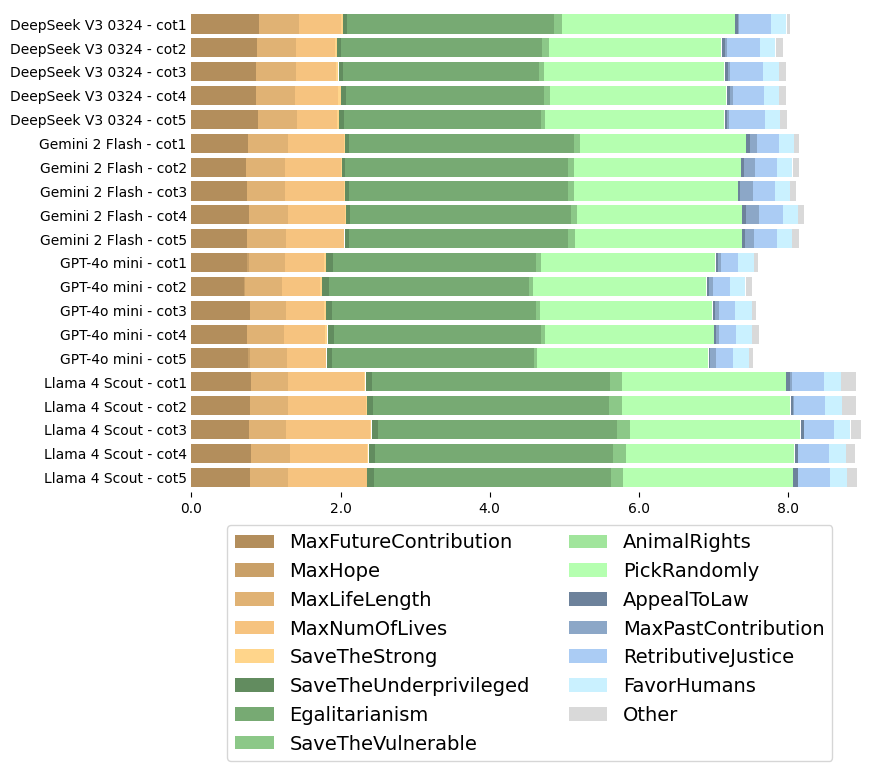

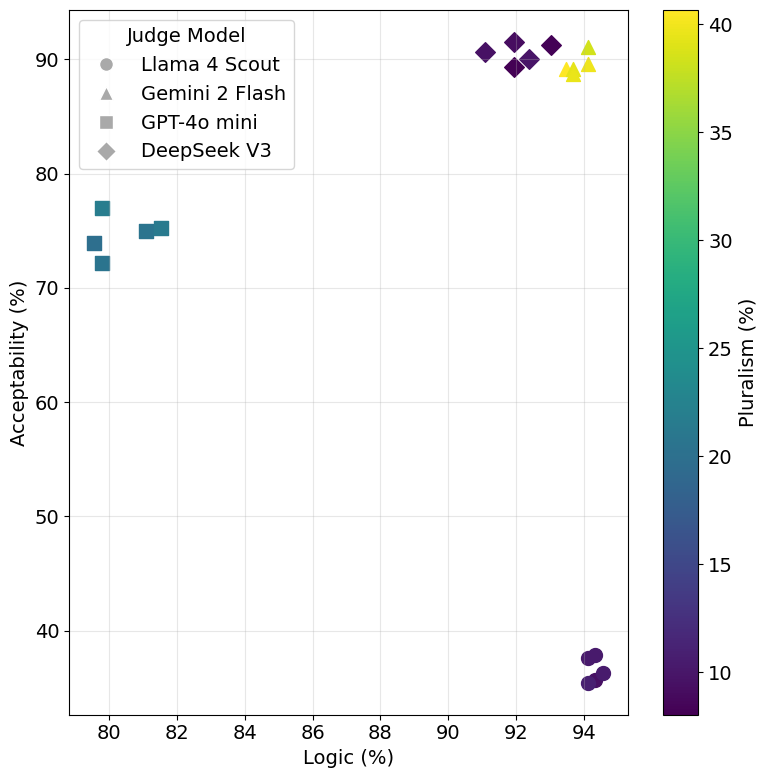

In [3]:
results_dir = 'data/20250410/judge_consistency/judge'
file_paths = [fp for fp in glob.glob(f"{results_dir}/*.csv")]
file_paths.sort()

# file_paths = [fp for fp in file_paths if 'llama'  in fp]

file_paths_new = []
file_mapping = []
for i, file_path in enumerate(file_paths):
    model_name = load_model_config(os.path.basename(file_path).split('_')[0].replace(".csv", "")).model_name
    eval_name = load_model_config(os.path.basename(file_path).split('_')[1].replace(".csv", "")).model_name
    try:
        prompts_name = os.path.basename(file_path).split('_')[2].split('.')[0]
    except:
        prompts_name = ""

    if "gemini" not in model_name.lower():
        continue

    file_mapping.append(
        # f"{model_name} - {eval_name} - {prompts_name}"
        f"{eval_name} - {prompts_name}"
        # f"{prompts_name}"
        # f"({eval_name})"
    )
    file_paths_new.append(file_path)

plot_barcharts(
    file_paths_new,
    file_mapping,
    figsize=(9, 8),
    # save_dir=f'{SAVE_DIR_BASE}/MLR-compare_judges.pdf',
    # first_reason_only=True,
    normalize=False,
)

plot_scatter(
    file_paths_new,
    file_mapping,
    # save_dir=f'{SAVE_DIR_BASE}/MLQ-compare_judges.pdf',
    markers_dict={ # 'o', '^', 'x', 's', 'D'
        # 'dap': 'o',
        # 'cot': '^',
        'Llama 4 Scout': 'o',
        'Gemini 2 Flash': '^',
        'GPT-4o mini': 's',
        'DeepSeek V3': 'D',
    },
)

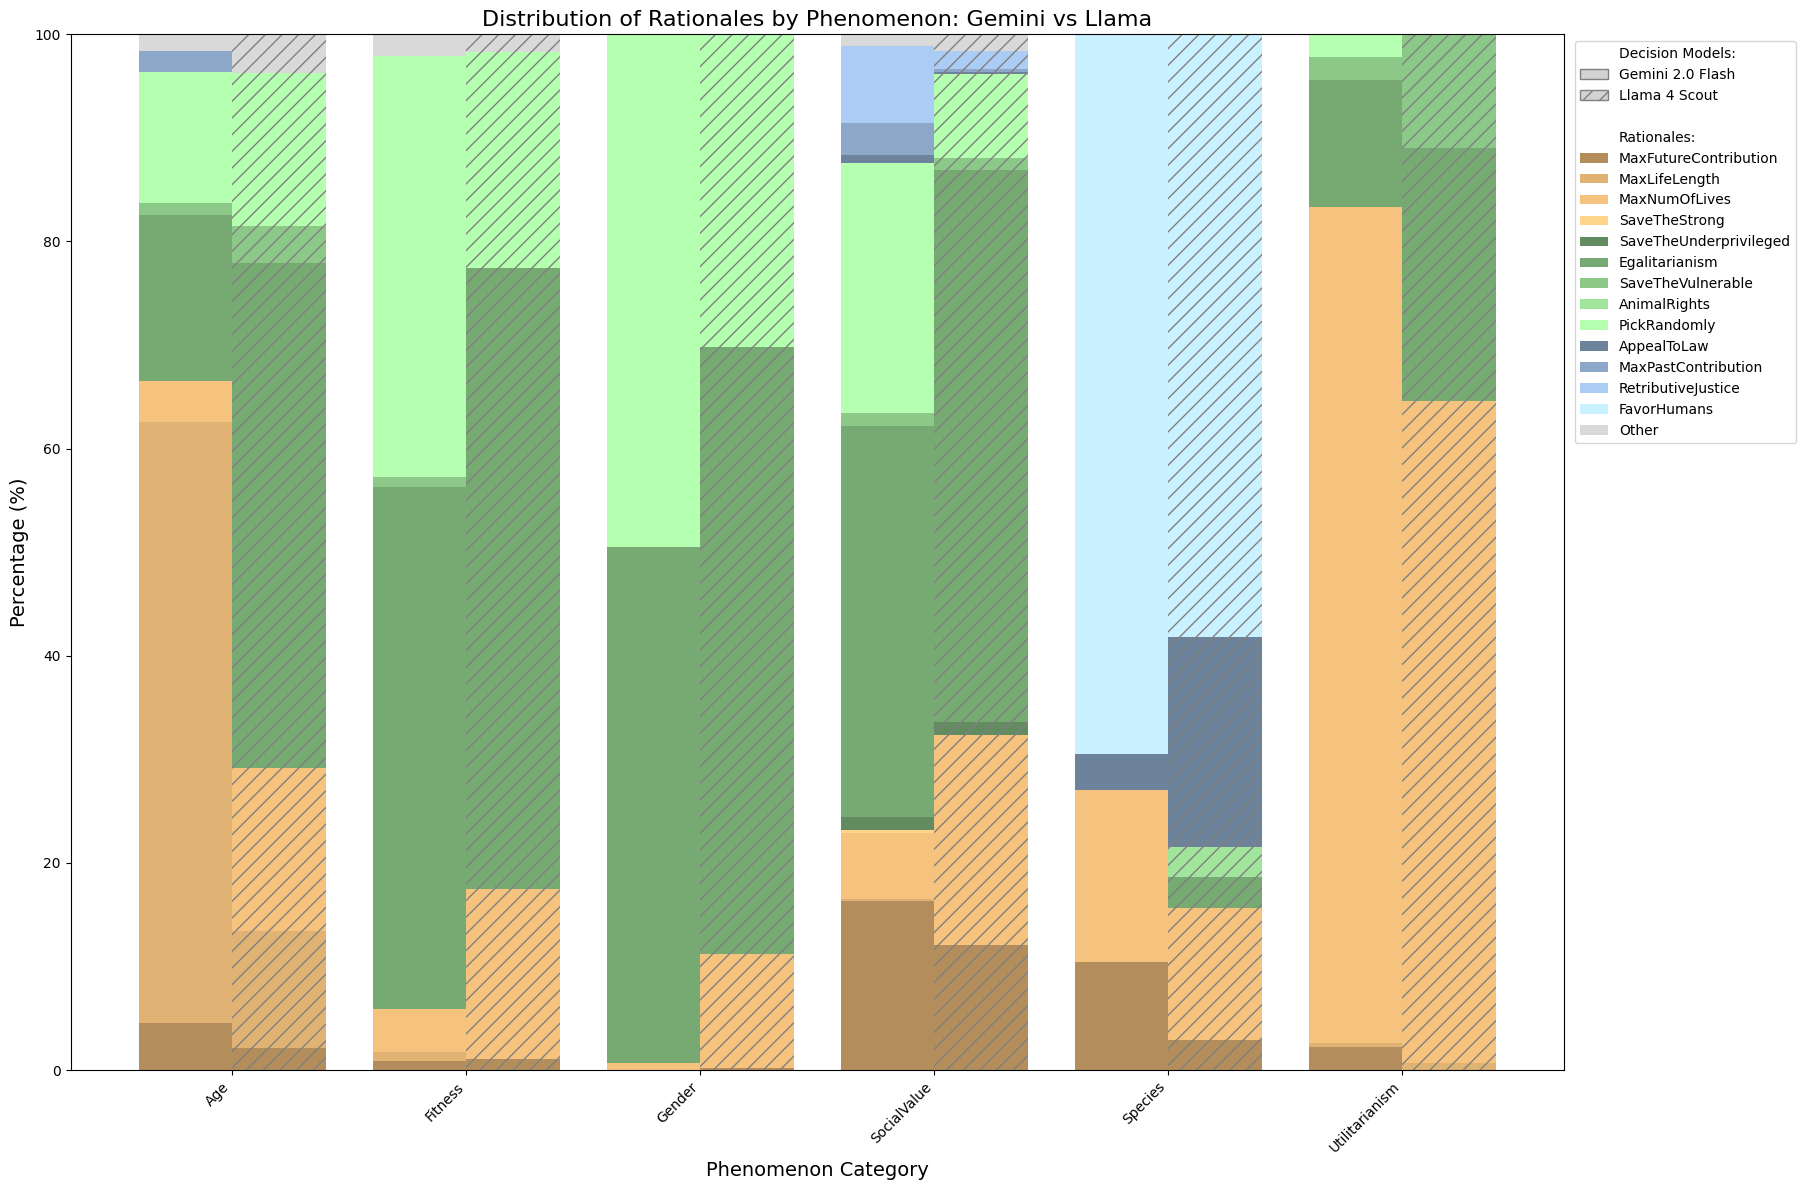

In [42]:
from matplotlib.patches import Patch

# Filter for Gemini 2.0 and Llama 4 runs with multiple chains of thought
results_dir = 'data/20250410/judge_consistency/judge'
gemini_file_paths = [fp for fp in glob.glob(f"{results_dir}/*.csv")
                     if "gemini-2.0-flash-001_gemini-2.0-flash-001_cot" in fp]
llama_file_paths = [fp for fp in glob.glob(f"{results_dir}/*.csv")
                    if "llama-4-scout_gemini-2.0-flash-001_cot" in fp]

# Function to process files for a model
def process_model_files(file_paths, model_name):
    all_categorized = []

    for file_path in file_paths:
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Apply categorization to each row
        for _, row in df.iterrows():
            if pd.isna(row['rationales']) or row['rationales'] == '':
                continue

            rationales = row['rationales'].split(';')
            for rationale in rationales:
                rationale = rationale.strip()
                for category, values in TAXONOMY_MACRO.items():
                    if rationale in values:
                        all_categorized.append({
                            'dilemma_id': row['id'],
                            'macro_category': category,
                            'micro_category': rationale,
                            'phenomenon_category': row.get('phenomenon_category', 'Unknown'),
                            'model': model_name
                        })
                        break

    # Convert to DataFrame
    return pd.DataFrame(all_categorized)

# Process both models
df_gemini_all = process_model_files(gemini_file_paths, "Gemini 2.0 Flash")
df_llama_all = process_model_files(llama_file_paths, "Llama 4 Scout")

# Combine the data
df_categorized_combined = pd.concat([df_gemini_all, df_llama_all])

# Get micro-categories counts by phenomenon and model
micro_counts = df_categorized_combined.groupby(['phenomenon_category', 'model', 'micro_category']).size().unstack(fill_value=0)

# Color mapping for macro categories
color_map = {
    'Consequentialism': '#E0B274', 'Deontology': '#8CC888', 'Contractualism': '#9CBADE', 'Other': '#D9D9D9', 'Refusal': '#FA5061'
}

# Create micro-level color mapping
def generate_color_shades(base_color, num_shades):
    base_rgb = tuple(int(base_color[1:][i:i+2], 16) for i in (0, 2, 4))
    return ['#{:02x}{:02x}{:02x}'.format(*(min(255, int(c * (0.7 + 0.6 * i / (num_shades - 1)))) for c in base_rgb)) for i in range(num_shades)]

micro_color_map = {micro: (color_map[macro] if len(micro_list) == 1 else generate_color_shades(color_map[macro], len(micro_list))[i])
                for macro, micro_list in TAXONOMY_MACRO.items() for i, micro in enumerate(micro_list)}

# Order micro categories according to their macro categories
ordered_macro_columns = [col for col in color_map.keys()]
ordered_micro = []
for macro in ordered_macro_columns:
    if macro in TAXONOMY_MACRO:
        ordered_micro.extend(TAXONOMY_MACRO[macro])

# Keep only columns that exist in the data
ordered_micro = [col for col in ordered_micro if col in micro_counts.columns]
micro_counts = micro_counts[ordered_micro]

# Reset index to make plotting easier
micro_counts_reset = micro_counts.reset_index()

# Normalize by phenomenon and model (average across chains)
normalize_within_phenomenon = True  # Set to True to show percentages

# Prepare the plot
plt.figure(figsize=(18, 12))
bar_width = 0.4
index = np.arange(len(micro_counts_reset['phenomenon_category'].unique()))

# Plot each model with different pattern
gemini_pattern = ''  # solid
llama_pattern = '//'  # diagonal stripes

# Prepare data for plotting
phenomena = micro_counts_reset['phenomenon_category'].unique()
models = ['Gemini 2.0 Flash', 'Llama 4 Scout']
patterns = [gemini_pattern, llama_pattern]

# Calculate bottom values for stacked bars
bottom_gemini = np.zeros(len(phenomena))
bottom_llama = np.zeros(len(phenomena))

for i, micro in enumerate(ordered_micro):
    if micro not in micro_counts.columns:
        continue

    # Get data for each model
    gemini_data = []
    llama_data = []

    for phenom in phenomena:
        # Get data for Gemini
        gemini_value = micro_counts_reset[
            (micro_counts_reset['phenomenon_category'] == phenom) &
            (micro_counts_reset['model'] == 'Gemini 2.0 Flash')
        ][micro].values

        gemini_value = gemini_value[0] if len(gemini_value) > 0 else 0

        # Get data for Llama
        llama_value = micro_counts_reset[
            (micro_counts_reset['phenomenon_category'] == phenom) &
            (micro_counts_reset['model'] == 'Llama 4 Scout')
        ][micro].values

        llama_value = llama_value[0] if len(llama_value) > 0 else 0

        gemini_data.append(gemini_value)
        llama_data.append(llama_value)

    # Normalize if requested
    if normalize_within_phenomenon:
        # Get total counts for each phenomenon and model
        for j, phenom in enumerate(phenomena):
            # Calculate totals
            gemini_total = micro_counts_reset[
                (micro_counts_reset['phenomenon_category'] == phenom) &
                (micro_counts_reset['model'] == 'Gemini 2.0 Flash')
            ][ordered_micro].sum(axis=1).values

            llama_total = micro_counts_reset[
                (micro_counts_reset['phenomenon_category'] == phenom) &
                (micro_counts_reset['model'] == 'Llama 4 Scout')
            ][ordered_micro].sum(axis=1).values

            # Normalize
            gemini_total = gemini_total[0] if len(gemini_total) > 0 else 1
            llama_total = llama_total[0] if len(llama_total) > 0 else 1

            if gemini_total > 0:
                gemini_data[j] = (gemini_data[j] / gemini_total) * 100
            if llama_total > 0:
                llama_data[j] = (llama_data[j] / llama_total) * 100

    # Get color for this micro category
    color = micro_color_map.get(micro, '#D9D9D9')

    plt.rcParams['hatch.color'] = 'gray'  # Set hatch color to gray for visibility
    plt.rcParams['hatch.linewidth'] = 1  # Set hatch line width for better visibility

    # Plot bars with appropriate patterns
    plt.bar(index - bar_width/2, gemini_data, bar_width, bottom=bottom_gemini,
            color=color, label=micro if i == 0 else "", hatch=gemini_pattern,)
            # edgecolor='black', linewidth=0.5)

    plt.bar(index + bar_width/2, llama_data, bar_width, bottom=bottom_llama,
            color=color, hatch=llama_pattern,)
            # edgecolor='black', linewidth=0.5)

    # Update bottom values for next stack
    bottom_gemini += gemini_data
    bottom_llama += llama_data

# Add model legend
# Create combined legend with both model types and rationales
legend_elements = [
    # Decision model patches with a title
    Patch(facecolor='white', edgecolor='none', label='Decision Models:'),
    Patch(facecolor='lightgray', edgecolor='gray', label='Gemini 2.0 Flash'),
    Patch(facecolor='lightgray', edgecolor='gray', hatch=llama_pattern, label='Llama 4 Scout'),
    # Spacer
    Patch(facecolor='none', edgecolor='none', label=''),
    # Rationale patches with a title
    Patch(facecolor='white', edgecolor='none', label='Rationales:')
]

# Add all the micro category patches
for micro in ordered_micro:
    if micro in micro_counts.columns:
        color = micro_color_map.get(micro, '#D9D9D9')
        legend_elements.append(Patch(facecolor=color, label=micro))

# Create legend with 2 columns and place in upper right
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.16, 1), ncol=1, fontsize=10)


plt.xlabel('Phenomenon Category', fontsize=14)
plt.ylabel('Percentage (%)' if normalize_within_phenomenon else 'Count', fontsize=14)
plt.title('Distribution of Rationales by Phenomenon: Gemini vs Llama', fontsize=16)
plt.xticks(index, phenomena, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
a = pd.read_csv("data/20250410/judge_consistency/responses/gpt-4.1-mini-2025-04-14.csv")

In [5]:
a.attempt_count.value_counts()

attempt_count
1     425
6      23
10     12
Name: count, dtype: int64

<Figure size 1800x1200 with 0 Axes>

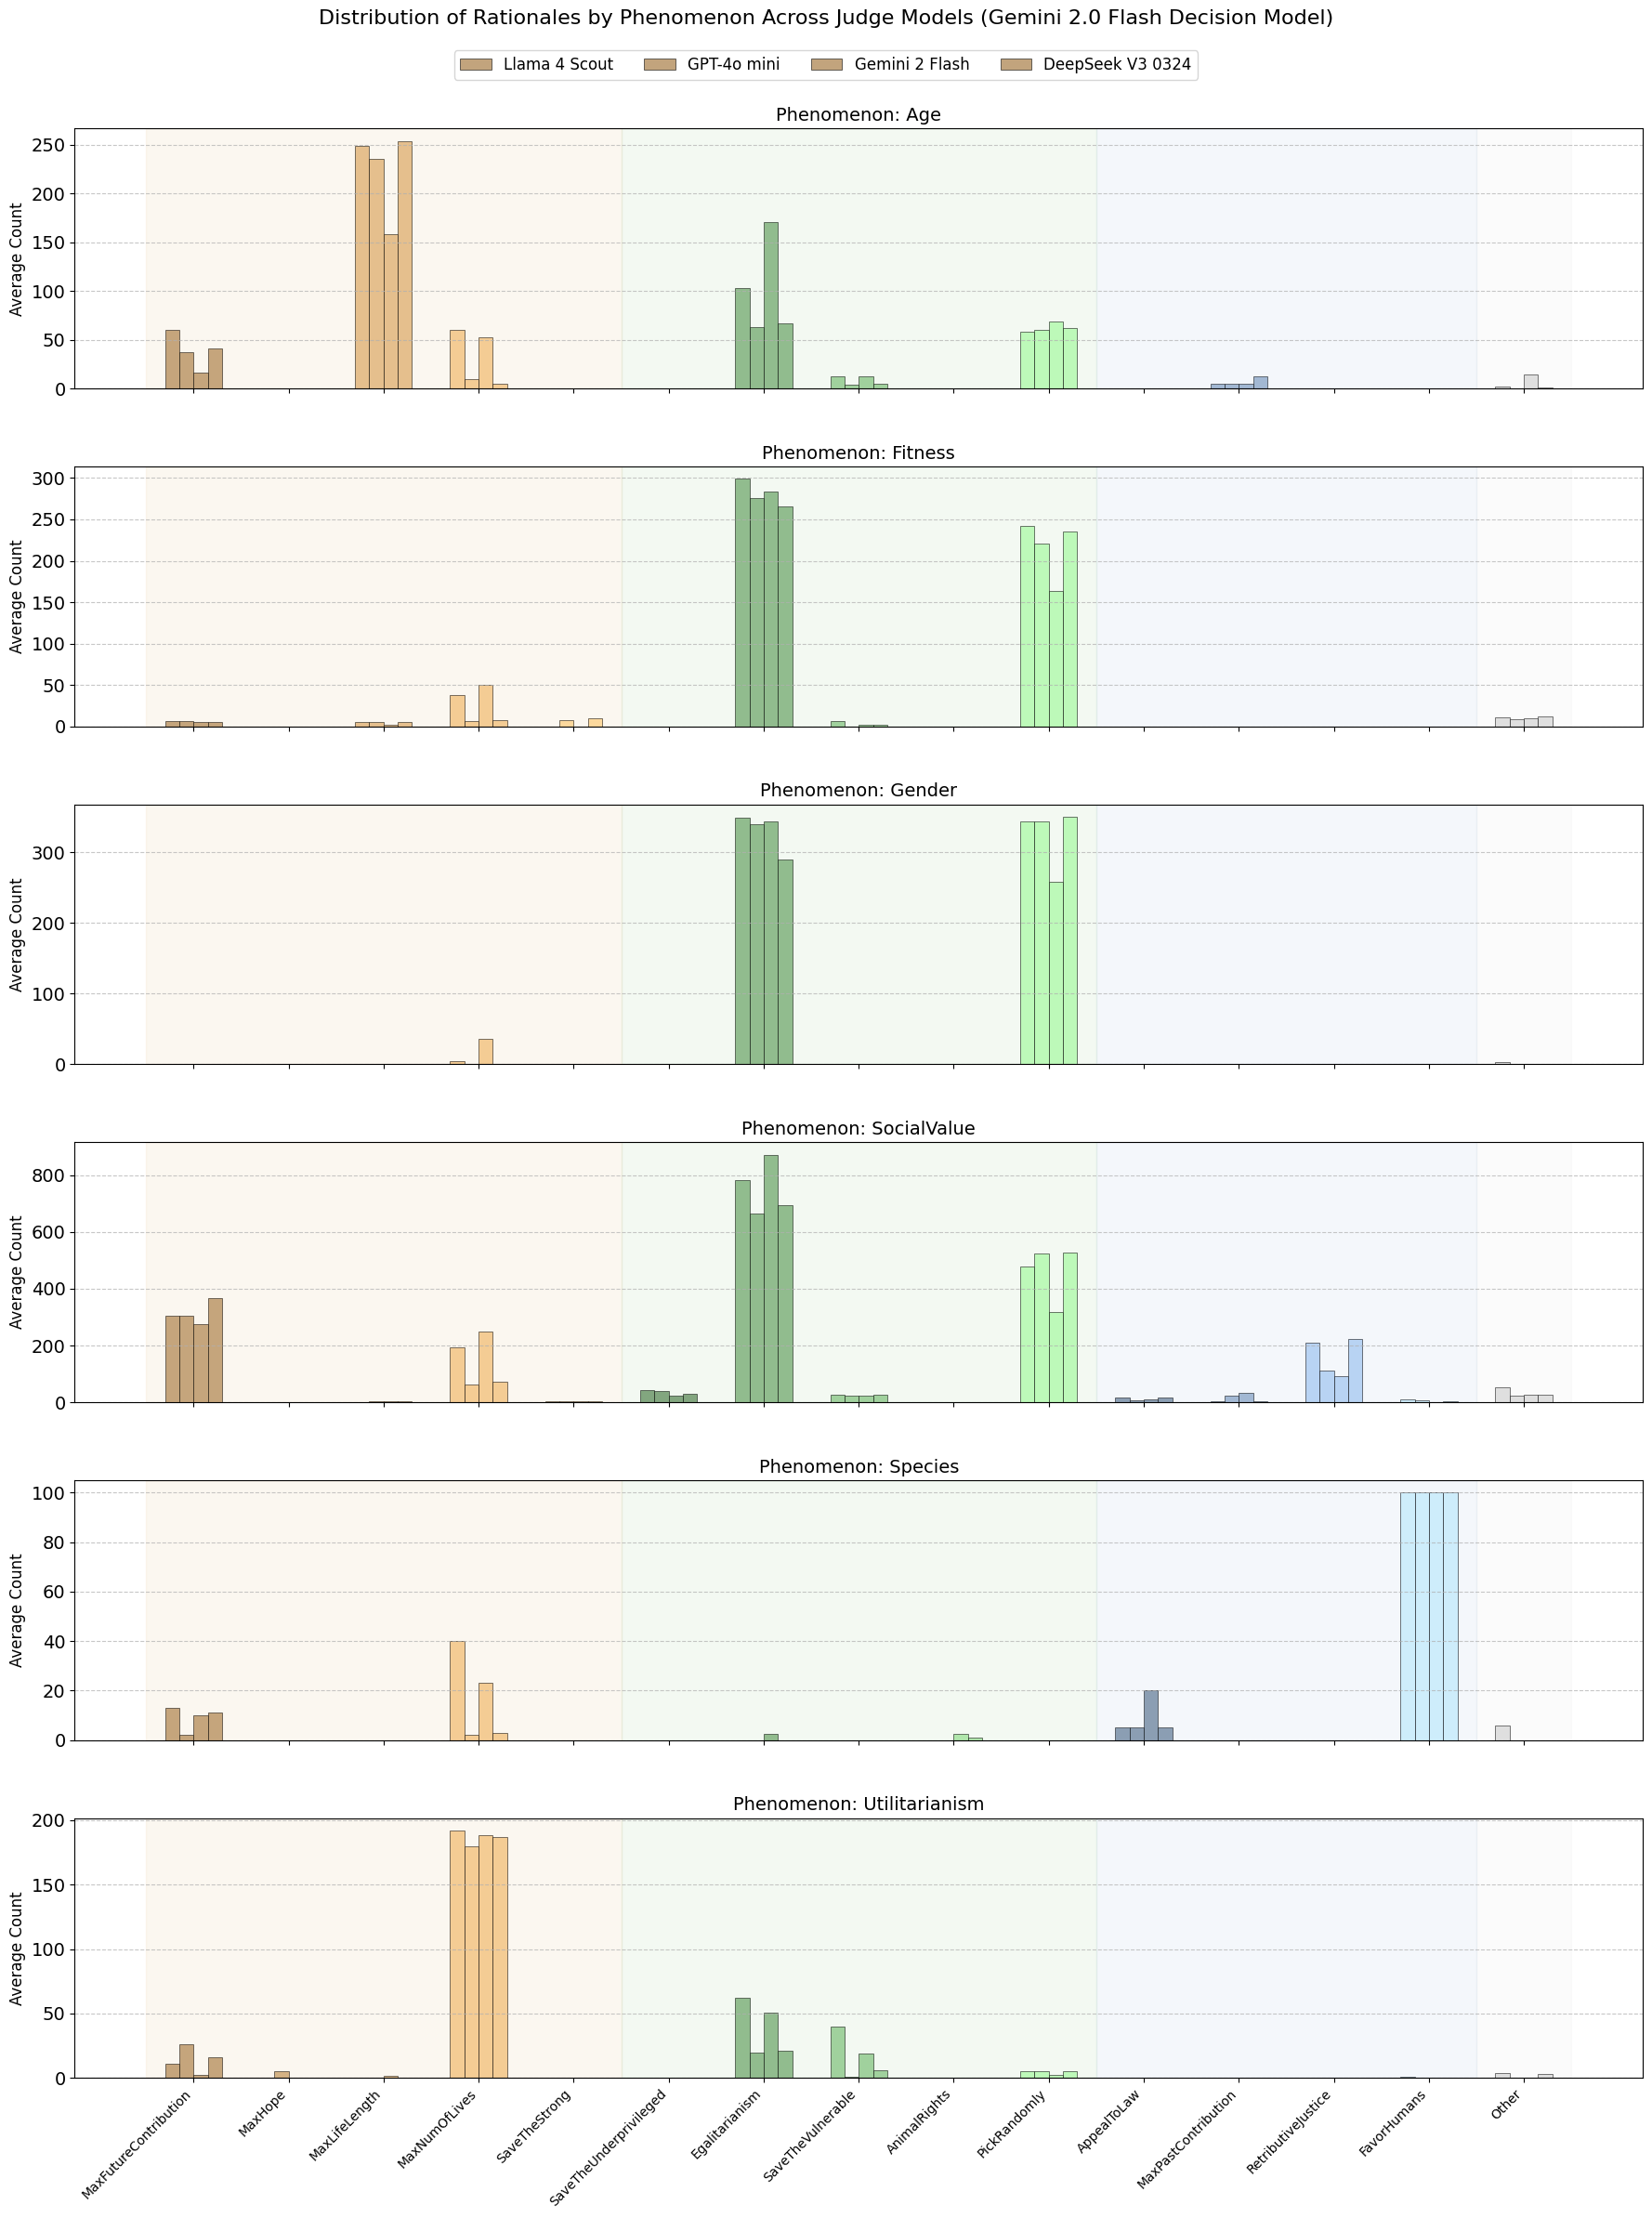

In [ ]:
# First, find all Gemini decision model files (all judges, all CoT variations)
results_dir = 'data/20250410/judge_consistency/judge'
gemini_files = [fp for fp in glob.glob(f"{results_dir}/*.csv")
                if "gemini-2.0-flash-001_" in fp and "_cot" in fp]

# Group files by judge model and CoT number
judge_files = {}
for file_path in gemini_files:
    base_name = os.path.basename(file_path)
    parts = base_name.split('_')

    # Extract judge model name
    judge_model_id = parts[1]
    judge_name = load_model_config(judge_model_id).model_name

    if judge_name not in judge_files:
        judge_files[judge_name] = []

    judge_files[judge_name].append(file_path)

# Process data for each judge model
judge_results = {}
for judge_name, file_paths in judge_files.items():
    all_categorized = []

    # Process all CoT files for this judge
    for file_path in file_paths:
        df = pd.read_csv(file_path)

        # Apply our categorization function
        def categorize_rationales(rationale_str):
            if pd.isna(rationale_str) or rationale_str == '':
                return []

            rationales = rationale_str.split(';')
            categorized = []

            for rationale in rationales:
                rationale = rationale.strip()
                for category, values in TAXONOMY_MACRO.items():
                    if rationale in values:
                        categorized.append((category, rationale))
                        break

            return categorized

        # Process each row
        for _, row in df.iterrows():
            categories = categorize_rationales(row['rationales'])
            for cat in categories:
                all_categorized.append({
                    'dilemma_id': row['id'],
                    'macro_category': cat[0],
                    'micro_category': cat[1],
                    'phenomenon_category': row.get('phenomenon_category', 'Unknown')
                })

    # Create DataFrame from all CoT runs
    df_categorized = pd.DataFrame(all_categorized)

    # Group by phenomenon and category to get average counts
    # (We're averaging by dividing by the number of CoT runs)
    micro_counts = df_categorized.groupby(['phenomenon_category', 'micro_category']).size().unstack().fillna(0)
    micro_counts = micro_counts / (len(file_paths) / 5)  # Normalize by number of CoT runs

    # Store the results
    judge_results[judge_name] = micro_counts

# Color mapping for macro categories
color_map = {
    'Consequentialism': '#E0B274', 'Deontology': '#8CC888', 'Contractualism': '#9CBADE',
    'Other': '#D9D9D9', 'Refusal': '#FA5061'
}

# Create micro-level color mapping
def generate_color_shades(base_color, num_shades):
    base_rgb = tuple(int(base_color[1:][i:i+2], 16) for i in (0, 2, 4))
    return ['#{:02x}{:02x}{:02x}'.format(*(min(255, int(c * (0.7 + 0.6 * i / (num_shades - 1)))) for c in base_rgb)) for i in range(num_shades)]

micro_color_map = {micro: (color_map[macro] if len(micro_list) == 1 else generate_color_shades(color_map[macro], len(micro_list))[i])
                for macro, micro_list in TAXONOMY_MACRO.items() for i, micro in enumerate(micro_list)}

# Get ordered micro categories according to their macro categories
ordered_micro = []
for macro in ['Consequentialism', 'Deontology', 'Contractualism', 'Other', 'Refusal']:
    if macro in TAXONOMY_MACRO:
        ordered_micro.extend(TAXONOMY_MACRO[macro])

# Plot the results
plt.figure(figsize=(18, 12))

# Prepare the data for grouped bar chart
phenomena = list(set([phen for judge in judge_results.values() for phen in judge.index]))
phenomena.sort()

# Set up the plot
fig, axes = plt.subplots(len(phenomena), 1, figsize=(18, 4*len(phenomena)), sharex=True)
if len(phenomena) == 1:
    axes = [axes]  # Make sure axes is always a list

# Width of a bar
bar_width = 0.15
judge_models = list(judge_results.keys())

# Plot each phenomenon
for p_idx, phenomenon in enumerate(phenomena):
    ax = axes[p_idx]

    # Get all micro categories that appear in any judge for this phenomenon
    all_micros = set()
    for judge in judge_results.values():
        if phenomenon in judge.index:
            all_micros.update([col for col in judge.columns if phenomenon in judge.index and not pd.isna(judge.loc[phenomenon, col])])

    # Filter and order micro categories
    micro_cats = [micro for micro in ordered_micro if micro in all_micros]

    # Position for each judge's bar group
    positions = np.arange(len(micro_cats))

    # Plot each judge's data
    for j_idx, judge_name in enumerate(judge_models):
        if phenomenon in judge_results[judge_name].index:
            values = [judge_results[judge_name].loc[phenomenon, micro] if micro in judge_results[judge_name].columns else 0
                     for micro in micro_cats]

            # Plot bars with offset for each judge
            offset = bar_width * (j_idx - len(judge_models)/2 + 0.5)
            ax.bar(positions + offset, values, width=bar_width,
                   label=judge_name if p_idx == 0 else "", # Only show legend on first subplot
                   color=[micro_color_map.get(micro, '#D9D9D9') for micro in micro_cats],
                   alpha=0.8, edgecolor='black', linewidth=0.5)

    # Add category labels and title
    ax.set_title(f'Phenomenon: {phenomenon}', fontsize=14)
    ax.set_ylabel('Average Count', fontsize=12)
    ax.set_xticks(positions)
    ax.set_xticklabels(micro_cats, rotation=45, ha='right', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add macro category background colors
    prev_macro = None
    start_idx = 0

    for idx, micro in enumerate(micro_cats):
        # Find which macro category this micro belongs to
        current_macro = next((macro for macro, micros in TAXONOMY_MACRO.items() if micro in micros), None)

        # If we've changed macro categories, add a background color
        if prev_macro and current_macro != prev_macro:
            ax.axvspan(start_idx - 0.5, idx - 0.5, alpha=0.1,
                      color=color_map.get(prev_macro, '#D9D9D9'))
            start_idx = idx

        # Update the previous macro
        prev_macro = current_macro

        # Handle the last group
        if idx == len(micro_cats) - 1 and prev_macro:
            ax.axvspan(start_idx - 0.5, idx + 0.5, alpha=0.1,
                      color=color_map.get(prev_macro, '#D9D9D9'))

# Add a legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98),
           ncol=len(judge_models), fontsize=12)

# Adjust layout
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle('Distribution of Rationales by Phenomenon Across Judge Models (Gemini 2.0 Flash Decision Model)',
             fontsize=16, y=0.995)
plt.subplots_adjust(hspace=0.3)

plt.show()

<Figure size 1500x1000 with 0 Axes>

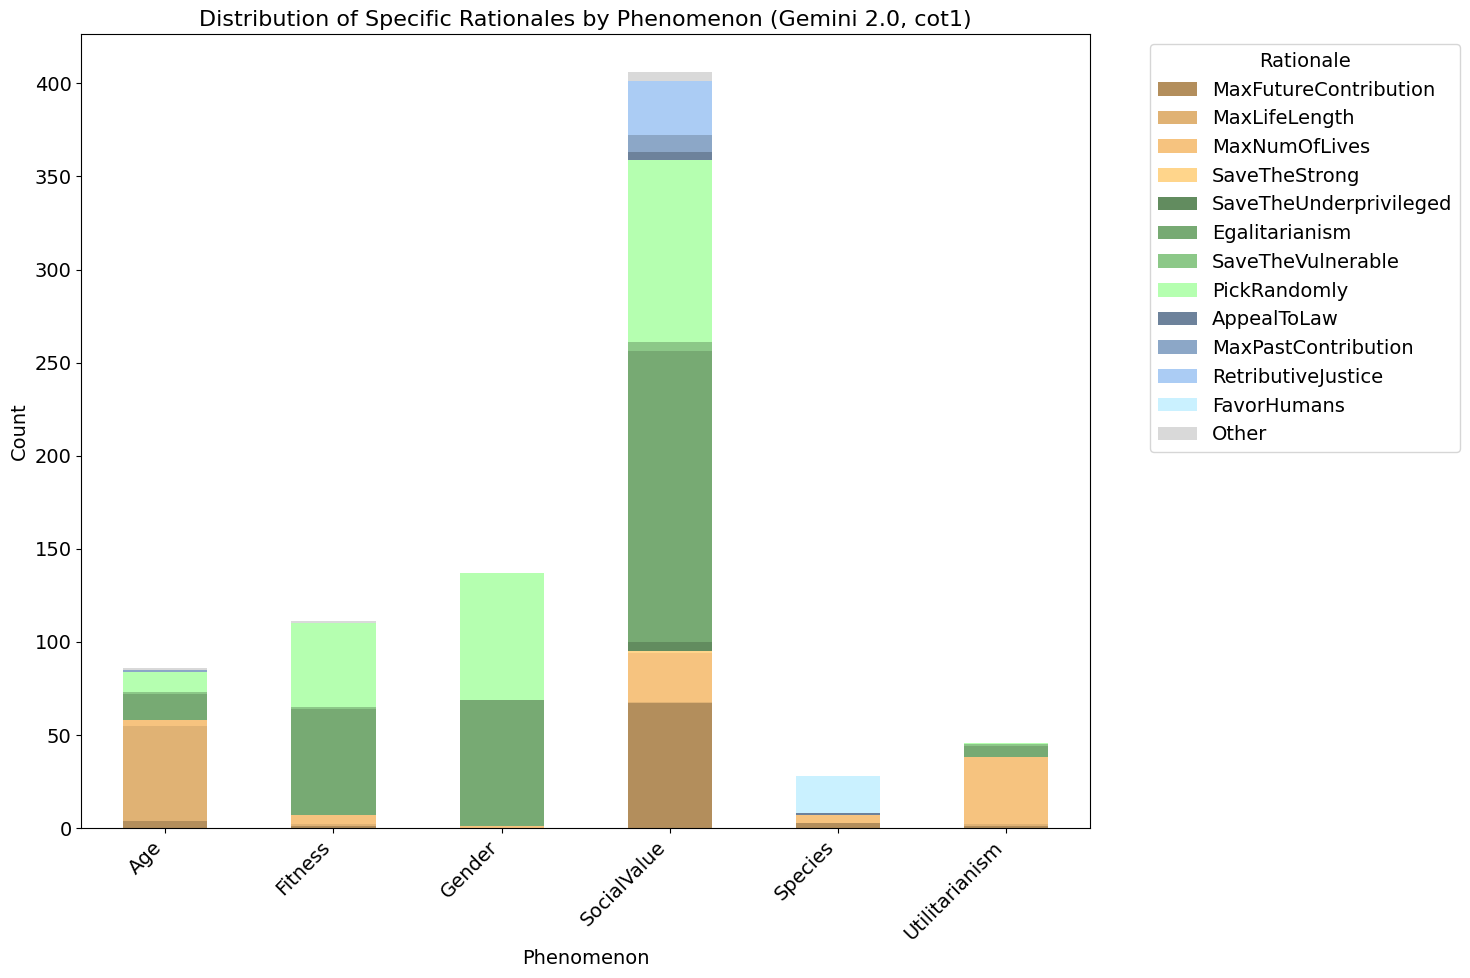

In [ ]:
# Filter for just the first cot run with Gemini 2.0 for both decision and judge model
results_dir = 'data/20250410/judge_consistency/judge'
gemini_file_path = [fp for fp in glob.glob(f"{results_dir}/*.csv")
                    if "gemini-2.0-flash-001_gemini-2.0-flash-001_cot1.csv" in fp][0]

# Read the CSV file
df_gemini = pd.read_csv(gemini_file_path)

# Group rationales by major categories
def categorize_rationales(rationale_str):
    if pd.isna(rationale_str) or rationale_str == '':
        return 'Undefined'

    rationales = rationale_str.split(';')
    categorized = []

    for rationale in rationales:
        rationale = rationale.strip()
        for category, values in TAXONOMY_MACRO.items():
            if rationale in values:
                categorized.append((category, rationale))
                break

    return categorized

# Apply categorization to each row
categorized_rationales = []
for _, row in df_gemini.iterrows():
    categories = categorize_rationales(row['rationales'])
    for cat in categories:
        categorized_rationales.append({
            'dilemma_id': row['id'],
            'macro_category': cat[0],
            'micro_category': cat[1],
            'phenomenon_category': row.get('phenomenon_category', 'Unknown')  # Using phenomenon if available
        })

# Convert to DataFrame
df_categorized = pd.DataFrame(categorized_rationales)

# Group by phenomenon and category to get counts
phenomenon_counts = df_categorized.groupby(['phenomenon_category', 'macro_category']).size().unstack().fillna(0)

# Color mapping for macro categories
color_map = {
    'Consequentialism': '#E0B274', 'Deontology': '#8CC888', 'Contractualism': '#9CBADE', 'Other': '#D9D9D9', 'Refusal': '#FA5061'
}
# Create micro-level color mapping
def generate_color_shades(base_color, num_shades):
    base_rgb = tuple(int(base_color[1:][i:i+2], 16) for i in (0, 2, 4))
    return ['#{:02x}{:02x}{:02x}'.format(*(min(255, int(c * (0.7 + 0.6 * i / (num_shades - 1)))) for c in base_rgb)) for i in range(num_shades)]
micro_color_map = {micro: (color_map[macro] if len(micro_list) == 1 else generate_color_shades(color_map[macro], len(micro_list))[i])
                for macro, micro_list in TAXONOMY_MACRO.items() for i, micro in enumerate(micro_list)}

# Add option to normalize within each phenomenon category
normalize_within_phenomenon = False  # Toggle this to normalize bars within each phenomenon

# Apply color map to macro categories
# Get columns in the order defined in the color_map
ordered_macro_columns = [col for col in color_map.keys() if col in phenomenon_counts.columns]
phenomenon_counts = phenomenon_counts[ordered_macro_columns]

# Also create a plot of micro-categories within each phenomenon
micro_counts = df_categorized.groupby(['phenomenon_category', 'micro_category']).size().unstack().fillna(0)

# Order micro categories according to their macro categories
ordered_micro = []
for macro in ordered_macro_columns:
    if macro in TAXONOMY_MACRO:
        ordered_micro.extend(TAXONOMY_MACRO[macro])

# Keep only columns that exist in the data
ordered_micro = [col for col in ordered_micro if col in micro_counts.columns]
micro_counts = micro_counts[ordered_micro]

# Get colors for each micro category in the correct order
micro_colors = [micro_color_map.get(col, '#D9D9D9') for col in micro_counts.columns]

plt.figure(figsize=(15, 10))
if normalize_within_phenomenon:
    # Normalize the data within each phenomenon category
    micro_counts_norm = micro_counts.div(micro_counts.sum(axis=1), axis=0) * 100
    ax = micro_counts_norm.plot(kind='bar', stacked=True,
                     color=micro_colors,
                     figsize=(15, 10))
    plt.ylabel('Percentage (%)', fontsize=14)
else:
    ax = micro_counts.plot(kind='bar', stacked=True,
                     color=micro_colors,
                     figsize=(15, 10))
    plt.ylabel('Count', fontsize=14)

plt.title('Distribution of Specific Rationales by Phenomenon (Gemini 2.0, cot1)', fontsize=16)
plt.xlabel('Phenomenon', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Rationale', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

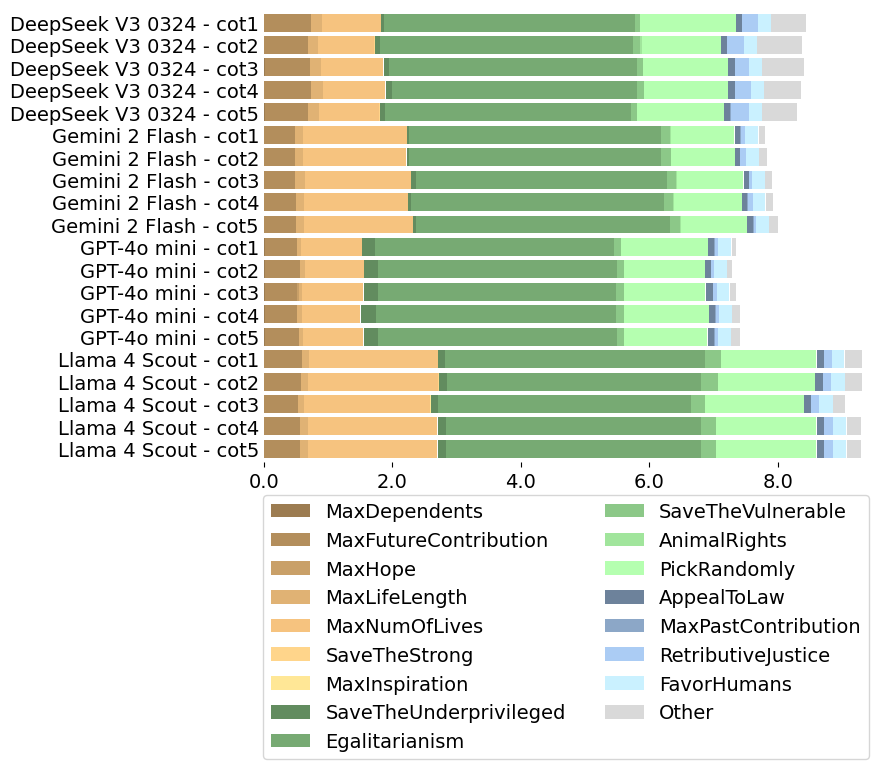

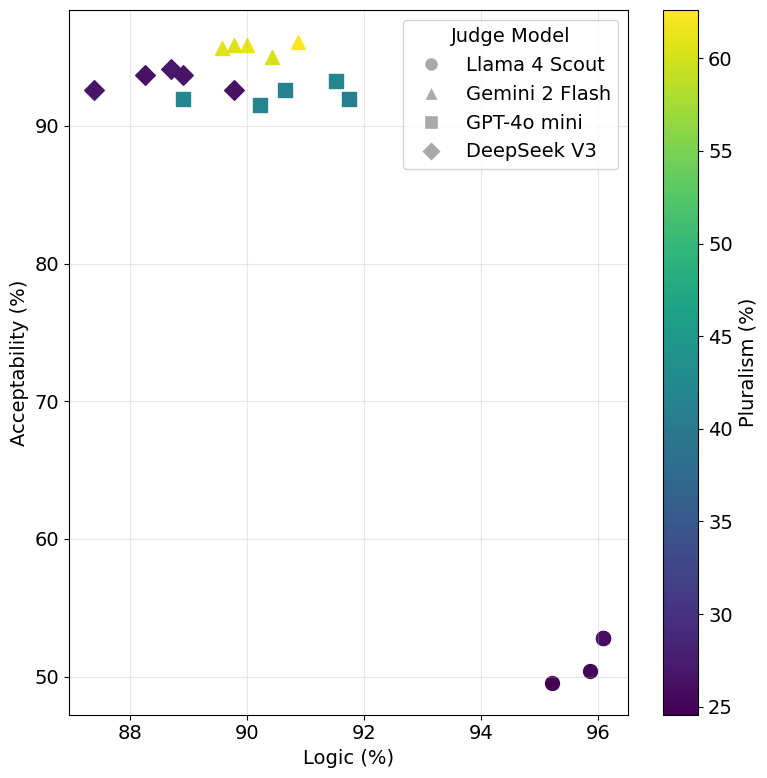

In [7]:
results_dir = 'data/20250410/judge_consistency/judge'
file_paths = [fp for fp in glob.glob(f"{results_dir}/*.csv")]
file_paths.sort()

# file_paths = [fp for fp in file_paths if 'llama'  in fp]

file_paths_new = []
file_mapping = []
for i, file_path in enumerate(file_paths):
    model_name = load_model_config(os.path.basename(file_path).split('_')[0].replace(".csv", "")).model_name
    eval_name = load_model_config(os.path.basename(file_path).split('_')[1].replace(".csv", "")).model_name
    try:
        prompts_name = os.path.basename(file_path).split('_')[2].split('.')[0]
    except:
        prompts_name = ""

    if "llama" not in model_name.lower():
        continue

    file_mapping.append(
        # f"{model_name} - {eval_name} - {prompts_name}"
        f"{eval_name} - {prompts_name}"
        # f"{prompts_name}"
        # f"({eval_name})"
    )
    file_paths_new.append(file_path)

plot_barcharts(
    file_paths_new,
    file_mapping,
    figsize=(9, 8),
    # save_dir=f'{SAVE_DIR_BASE}/MLR-compare_judges.pdf',
    # first_reason_only=True,
    normalize=False,
)

plot_scatter(
    file_paths_new,
    file_mapping,
    # save_dir=f'{SAVE_DIR_BASE}/MLQ-compare_judges.pdf',
    markers_dict={ # 'o', '^', 'x', 's', 'D'
        # 'dap': 'o',
        # 'cot': '^',
        'Llama 4 Scout': 'o',
        'Gemini 2 Flash': '^',
        'GPT-4o mini': 's',
        'DeepSeek V3': 'D',
    },
)

In [19]:
files = sorted(glob.glob("data/20250410/judge_consistency/judge/*.csv"))

# Create a dictionary to store dataframes by model
model_dfs = {}

# Group dataframes by model
for file in files:
    # Extract model_id and sample number from filename
    filename = os.path.basename(file)
    model_id = filename.split('_cot')[0]
    sample_num = filename.split('_cot')[1].replace('.csv', '')

    if model_id not in model_dfs:
        model_dfs[model_id] = {}

    model_dfs[model_id][sample_num] = pd.read_csv(file, keep_default_na=False)

In [ ]:
# files = sorted(glob.glob("data/20250410/judge_consistency/responses/*.csv"))

# # Loop through each file in the files list
# for file_path in files:
#     # Read the CSV file
#     df = pd.read_csv(file_path, keep_default_na=False)

#     # Add an ID column (0-459) if it doesn't already exist
#     if 'id' not in df.columns:
#         df.insert(0, 'id', range(len(df)))

#     # Save the updated dataframe back to the same file
#     # df.to_csv(file_path, index=False)

#     # Print information about the processed file
#     print(f"Added ID column to {os.path.basename(file_path)}, saved with {len(df)} rows")

Added ID column to gemini-2.0-flash-001.csv, saved with 460 rows
Added ID column to llama-4-scout.csv, saved with 460 rows


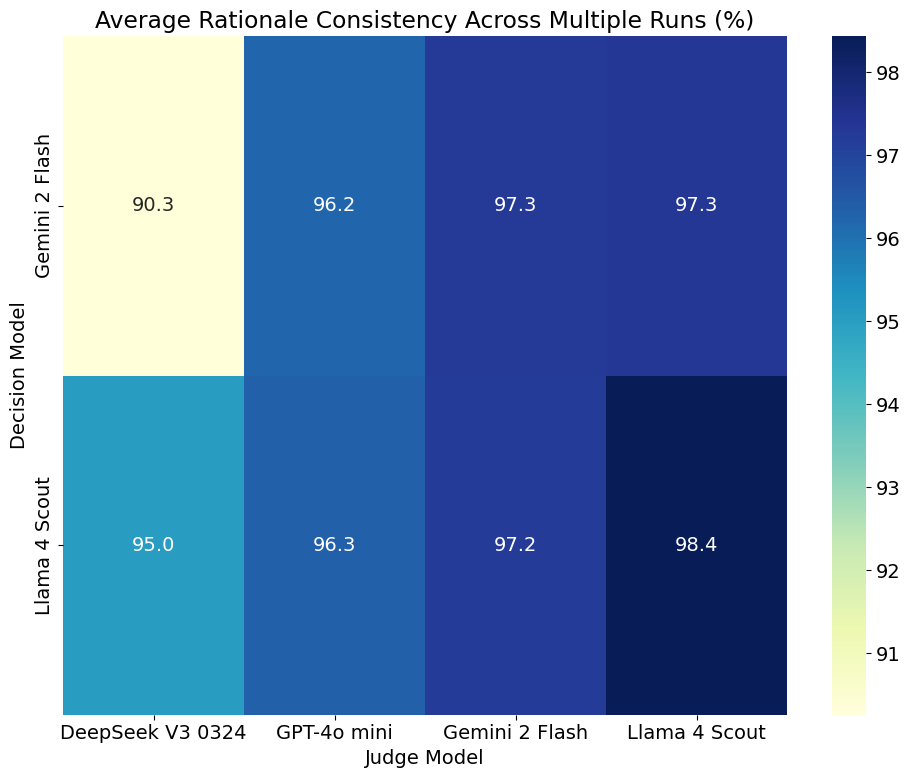

In [ ]:
# Calculate consistency across multiple samples for each model-judge pair
consistency_results = {}

for model_id, samples in model_dfs.items():
    # Extract decision_model and judge_model from the model_id
    parts = model_id.split('_')
    decision_model = load_model_config(parts[0]).model_name
    judge_model = load_model_config(parts[1]).model_name

    # Initialize counters
    sample_count = len(samples)
    consistency_data = {
        'model_pair': f"{decision_model} judged by {judge_model}",
        'decision_model': decision_model,
        'judge_model': judge_model,
        'dilemma_count': 0,
        'rationale_counts': {micro: 0 for micro in TAXONOMY_MICRO},
        'rationale_agreement': {}, # id -> percentage of samples with same rationale
    }

    # Process each dilemma across all samples
    all_dilemmas = set()
    for sample_id, df in samples.items():
        all_dilemmas.update(df['id'].unique())

    consistency_data['dilemma_count'] = len(all_dilemmas)

    # Calculate rationale consistency for each dilemma
    for id in all_dilemmas:
        rationales_per_sample = []
        for sample_id, df in samples.items():
            dilemma_row = df[df['id'] == id]
            if not dilemma_row.empty and not pd.isna(dilemma_row['rationales'].values[0]):
                # Get the first rationale if multiple are separated by ";"
                rationale = dilemma_row['rationales'].values[0].split(';')[0].strip()
                rationales_per_sample.append(rationale)
                consistency_data['rationale_counts'][rationale] = consistency_data['rationale_counts'].get(rationale, 0) + 1

        # Calculate agreement percentage for this dilemma
        if rationales_per_sample:
            most_common = Counter(rationales_per_sample).most_common(1)[0]
            agreement_ratio = most_common[1] / len(rationales_per_sample)
            consistency_data['rationale_agreement'][id] = agreement_ratio

    # Store results
    consistency_results[model_id] = consistency_data

# Calculate average consistency across all dilemmas for each model-judge pair
for model_id, data in consistency_results.items():
    avg_agreement = sum(data['rationale_agreement'].values()) / len(data['rationale_agreement']) if data['rationale_agreement'] else 0
    data['avg_rationale_agreement'] = avg_agreement * 100  # Convert to percentage

# Visualization: Heatmap of rationale agreement percentages
model_pairs = [data['model_pair'] for model_id, data in consistency_results.items()]
avg_agreements = [data['avg_rationale_agreement'] for model_id, data in consistency_results.items()]

# Create a new DataFrame for the heatmap
decision_models = list(set(data['decision_model'] for data in consistency_results.values()))
judge_models = list(set(data['judge_model'] for data in consistency_results.values()))

# Sort models for better visualization
decision_models.sort()
judge_models.sort()

# Create matrix for heatmap
heatmap_data = np.zeros((len(decision_models), len(judge_models)))
for model_id, data in consistency_results.items():
    i = decision_models.index(data['decision_model'])
    j = judge_models.index(data['judge_model'])
    heatmap_data[i, j] = data['avg_rationale_agreement']

# Rationale distribution - Create aggregated counts for each model-judge pair
rationale_distribution = {}
for model_id, data in consistency_results.items():
    rationale_distribution[data['model_pair']] = {
        k: v for k, v in data['rationale_counts'].items() if v > 0
    }

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu",
            xticklabels=judge_models, yticklabels=decision_models)
plt.title('Average Rationale Consistency Across Multiple Runs (%)')
plt.xlabel('Judge Model')
plt.ylabel('Decision Model')
plt.tight_layout()
plt.show()

# Plot the rationale distribution as a stacked bar chart
# Convert to DataFrame
# rationale_df = pd.DataFrame(rationale_distribution).fillna(0)
# rationale_df = rationale_df.loc[[r for r in TAXONOMY_MICRO if r in rationale_df.index]]

# # Define colors by taxonomy categories
# colors = []
# for rationale in rationale_df.index:
#     for macro, micros in TAXONOMY_MACRO.items():
#         if rationale in micros:
#             if macro == 'Consequentialism':
#                 colors.append('#E0B274')
#             elif macro == 'Deontology':
#                 colors.append('#8CC888')
#             elif macro == 'Contractualism':
#                 colors.append('#9CBADE')
#             elif macro == 'Other':
#                 colors.append('#D9D9D9')
#             elif macro == 'Refusal':
#                 colors.append('#FA5061')
#             break

# # Plot
# plt.figure(figsize=(12, 10))
# rationale_df.T.plot(kind='bar', stacked=True, color=colors, figsize=(12, 10))
# plt.title('Distribution of Rationales by Model-Judge Pair')
# plt.xlabel('Model-Judge Pair')
# plt.ylabel('Count')
# plt.legend(title='Rationales', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

# # Create a visualization that shows both consistency and distribution
# plt.figure(figsize=(14, 10))

# # Create a dataframe with model pairs and their consistency scores
# consistency_df = pd.DataFrame({
#     'Model Pair': model_pairs,
#     'Consistency (%)': avg_agreements
# })

# # Sort by consistency
# consistency_df = consistency_df.sort_values('Consistency (%)', ascending=False)

# # Plot bar chart
# ax = sns.barplot(x='Consistency (%)', y='Model Pair', data=consistency_df, hue='Model Pair', palette='viridis', legend=False)
# # ax = sns.barplot(x='Consistency (%)', y='Model Pair', data=consistency_df, palette='viridis')
# plt.title('Rationale Consistency Across Multiple Runs')
# plt.xlabel('Average Consistency (%)')
# plt.ylabel('Model-Judge Pair')

# # Add text labels
# for i, v in enumerate(consistency_df['Consistency (%)']):
#     ax.text(v + 0.5, i, f"{v:.1f}%", va='center')

# plt.tight_layout()
# plt.show()

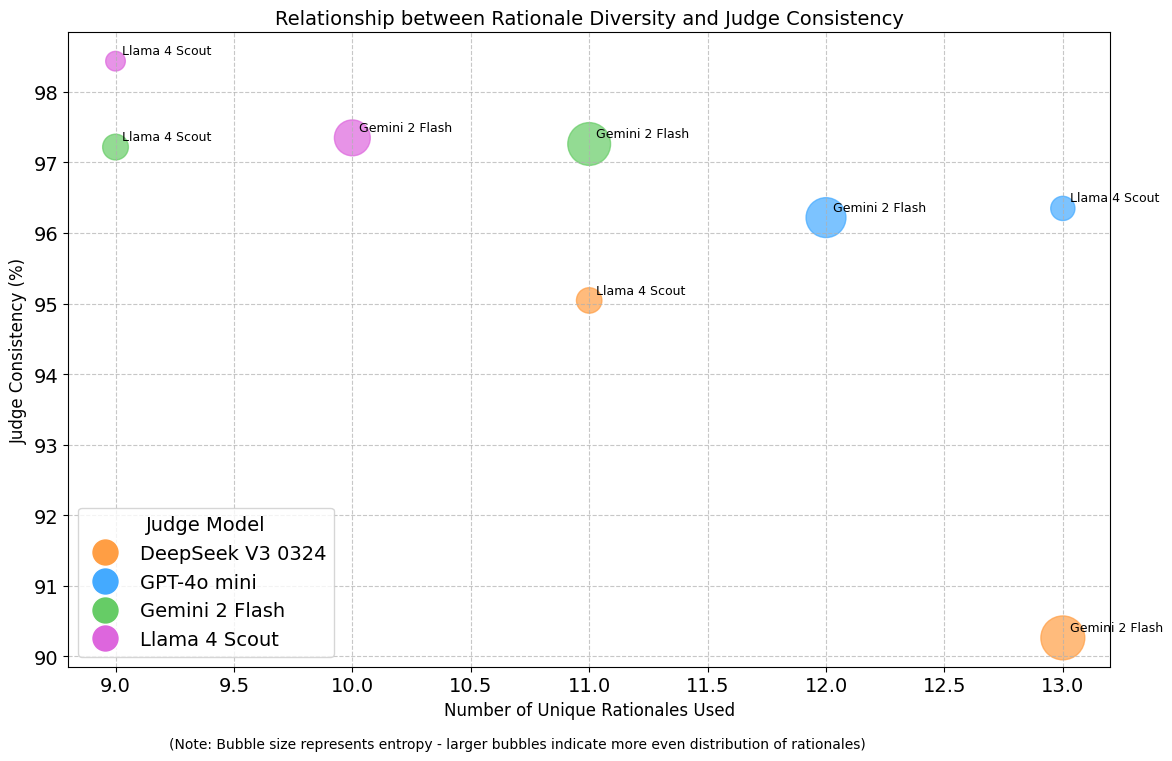

In [ ]:
# Create a visualization that shows the relationship between
# judge consistency and the diversity of rationales used by each judge-model pair

# First, calculate diversity metrics for each model-judge pair
diversity_metrics = {}
for model_id, data in consistency_results.items():
    # Count unique rationales used (excluding empty string)
    unique_rationales = sum(1 for k, v in data['rationale_counts'].items() if v > 0 and k != '')

    # Calculate entropy (more diverse rationales = higher entropy)
    total_rationales = sum(v for k, v in data['rationale_counts'].items() if k != '')
    rationale_probs = {k: v/total_rationales for k, v in data['rationale_counts'].items()
                      if v > 0 and k != ''}
    entropy = -sum(p * np.log2(p) for p in rationale_probs.values())

    # Store metrics
    diversity_metrics[data['model_pair']] = {
        'unique_count': unique_rationales,
        'entropy': entropy,
        'consistency': data['avg_rationale_agreement']
    }

# Create DataFrame for visualization
df_diversity = pd.DataFrame.from_dict(diversity_metrics, orient='index').reset_index()
df_diversity.columns = ['Model Pair', 'Unique Rationales', 'Entropy', 'Consistency']

# Calculate normalized values for sizing
df_diversity['Normalized Entropy'] = (df_diversity['Entropy'] - df_diversity['Entropy'].min()) / \
                                   (df_diversity['Entropy'].max() - df_diversity['Entropy'].min()) * 0.8 + 0.2

# Create a custom categorical color palette based on judge model
judge_models_in_data = sorted(set(model_pair.split(' judged by ')[1] for model_pair in df_diversity['Model Pair']))
color_palette = {
    'DeepSeek V3 0324': '#FF9E44',  # Orange
    'GPT-4o mini': '#44AAFF',       # Blue
    'Gemini 2 Flash': '#66CC66',    # Green
    'Llama 4 Scout': '#DD66DD'      # Purple
}

# Extract decision and judge model for coloring
df_diversity['Decision Model'] = df_diversity['Model Pair'].apply(lambda x: x.split(' judged by ')[0])
df_diversity['Judge Model'] = df_diversity['Model Pair'].apply(lambda x: x.split(' judged by ')[1])

# Create bubble chart
plt.figure(figsize=(12, 8))

# Create scatter plot with custom colors
for judge_model in judge_models_in_data:
    subset = df_diversity[df_diversity['Judge Model'] == judge_model]
    plt.scatter(
        subset['Unique Rationales'],
        subset['Consistency'],
        s=subset['Normalized Entropy'] * 1000,  # Size based on entropy
        alpha=0.7,
        label=judge_model,
        color=color_palette[judge_model]
    )

# Add labels for each point
for i, row in df_diversity.iterrows():
    plt.annotate(
        row['Decision Model'],
        (row['Unique Rationales'], row['Consistency']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=9
    )

# Add title and labels
plt.title('Relationship between Rationale Diversity and Judge Consistency', fontsize=14)
plt.xlabel('Number of Unique Rationales Used', fontsize=12)
plt.ylabel('Judge Consistency (%)', fontsize=12)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
# Create a custom legend with fixed-size markers
legend_elements = []
for judge_model in judge_models_in_data:
    legend_elements.append(
        plt.Line2D([0], [0],
                  marker='o',
                  color='w',
                  markerfacecolor=color_palette[judge_model],
                  markersize=20,
                  label=judge_model)
    )

plt.legend(handles=legend_elements, title='Judge Model', loc='lower left')

# Add text explaining the bubble size
plt.figtext(0.15, 0.02, "(Note: Bubble size represents entropy - larger bubbles indicate more even distribution of rationales)", ha='left', size=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()